In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import cm
import torch
# import skgstat as skg
import torch.nn as nn
# import geopandas as gpd 
import plotly.express as px
import torch.nn.functional as F
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.gaussian_process import GaussianProcessRegressor
import matplotlib.pyplot as plt
# plt.style.use('ggplot')

from sklearn.metrics import r2_score
import seaborn as sns

plt.rcParams['figure.figsize'] = (6,5)

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [3]:
Kscaled = pd.read_csv("Dataset/CleanedK.csv")
Oscaled = pd.read_csv("Dataset/CleanedOC.csv")
Pscaled = pd.read_csv("Dataset/CleanedP.csv")
Nscaled = pd.read_csv("Dataset/CleanedN.csv")

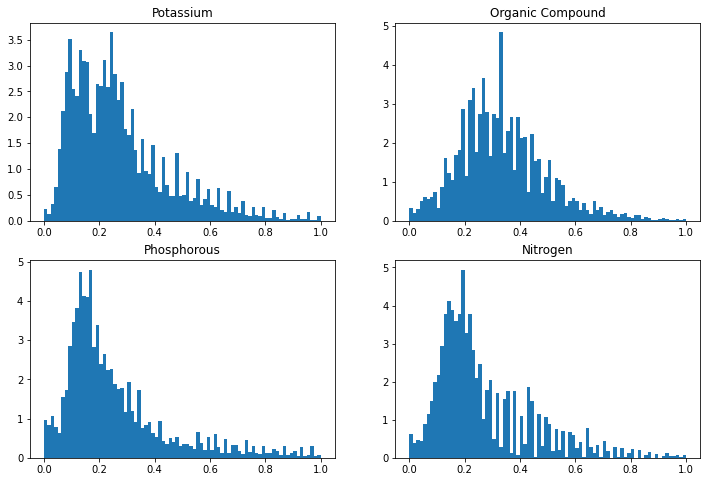

In [4]:
_,ax = plt.subplots(2,2,figsize = (12,8))
ax[0,0].hist(Kscaled['K'],bins = 80,density = True)
ax[0,0].set_title("Potassium")
ax[0,1].hist(Oscaled['OC'],bins = 80,density = True)
ax[0,1].set_title("Organic Compound")
ax[1,0].hist(Pscaled['P'],bins = 80,density = True)
ax[1,0].set_title("Phosphorous")
ax[1,1].hist(Nscaled['N'],bins = 80,density = True)
ax[1,1].set_title("Nitrogen")
plt.show()
             

In [5]:
data = pd.read_csv("Dataset/CleanedP.csv")

In [6]:
data.head()

,lat,lon,P
0,17.894722,73.401111,0.199450
1,17.894722,73.401389,0.194791
2,17.894722,73.402222,0.190133
3,17.894722,73.403056,0.204108
4,17.894722,73.403333,0.185475


In [7]:
data.corr()

,lat,lon,P
lat,1.000000,0.272859,0.499882
lon,0.272859,1.000000,0.061202
P,0.499882,0.061202,1.000000


## Data PreProcessing

In [8]:
#drop duplicates rows
data.drop_duplicates(subset=['lat', 'lon'], inplace = True)
data = data.reset_index(drop = True)
data.head()

,lat,lon,P
0,17.894722,73.401111,0.199450
1,17.894722,73.401389,0.194791
2,17.894722,73.402222,0.190133
3,17.894722,73.403056,0.204108
4,17.894722,73.403333,0.185475


In [9]:
data.shape

(24596, 3)

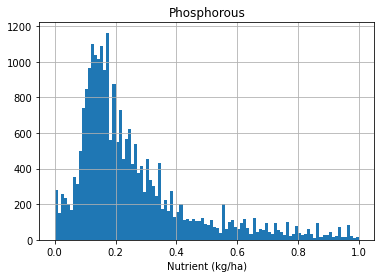

In [10]:
#visually check the distribution of data
data['P'].hist(bins = 100)
plt.title("Phosphorous")
plt.xlabel("Nutrient (kg/ha)")
plt.show()
plt.show()

<AxesSubplot:xlabel='P'>

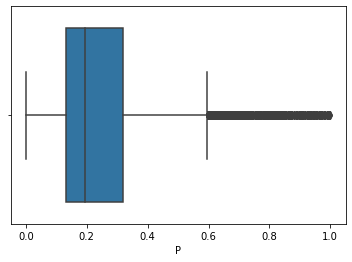

In [11]:
#create a boxplot to see whether there are outliers in the data or not.
sns.boxplot('P',data = data)

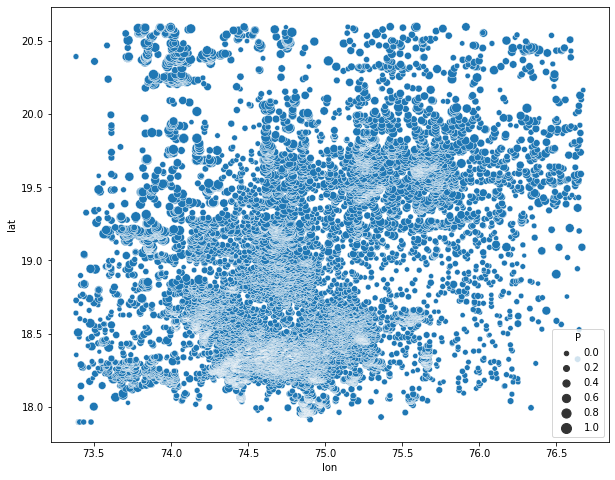

In [12]:
# scatetr plot to see the spatial distribution of the data
plt.figure(figsize=(10, 8))
sns.scatterplot(x ='lon', y ='lat',size ='P',sizes =(20, 100), data = data)
plt.show()

In [11]:
## Desnity plot
fig = px.density_mapbox(data, lat='lat', lon='lon', z='K', radius=8,
                         zoom=7,
                        mapbox_style="stamen-terrain", height=800)
fig.show()

### Split the data (80/20)

In [13]:
# split the data
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.25, random_state=0, shuffle = True)
test, val = train_test_split(test, test_size=0.20, random_state=0, shuffle=True)
print(f"Train shape: {train.shape}\nTest shape: {test.shape}\nValidation shape:{val.shape}")

Train shape: (18447, 3)
Test shape: (4919, 3)
Validation shape:(1230, 3)


In [14]:
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
val.reset_index(drop=True, inplace=True)
# train.head()

## Krigging

**Assumptions for Ordianry Krigging:**
1. Isotropy -  spatial data only depends on the distance separating them.
2. Spatial autocorrelation
3. Stationarity -  mean and variance is constant across the spatial field.

**Auto-correlation**\
Spatial auto-correaltion helps us to establish a relationship between neighbouring data. \
 We will use *morans'I* test to estimate the spatial autocorrelation. 



In [15]:
from geopandas import GeoDataFrame
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(train.lon, train.lat)]
df = train.copy().drop(['lon', 'lat'], axis=1)
gdf_ = GeoDataFrame(df, crs="EPSG:7767", geometry=geometry)
gdf_.head()

,P,geometry
0,0.132119,POINT (74.267 18.267)
1,0.048486,POINT (74.612 18.373)
2,0.065848,POINT (74.584 18.368)
3,0.173618,POINT (74.694 18.777)
4,0.408427,POINT (74.846 18.298)


In [17]:
# Moran's I test for global spatial autocorrelation
# Hypothesis:
# Null :  There is no global spatial autocorrelation
# Alternate :  There is spatial autocorrelation present among the datapoints
from libpysal.weights.contiguity import Queen
from esda.moran import Moran
from splot.esda import moran_scatterplot

# queen continuity based spatial weights
y = gdf_['P'].values

w = Queen.from_dataframe(gdf_)
moran = Moran(y, w)

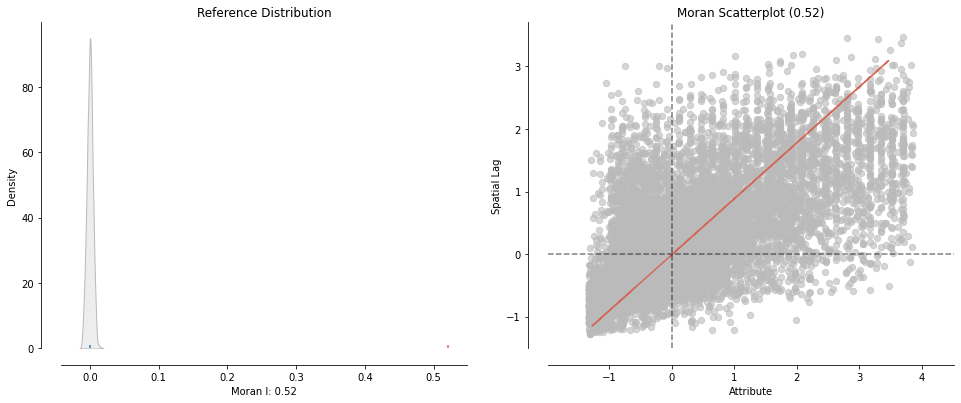

In [22]:
from splot.esda import plot_moran

#visulaize global autocorrelation statistics
plot_moran(moran, zstandard=True, figsize=(16,6))
plt.show()

In [23]:
# let's check for  statistics and p value
stats_, pval_ = moran.I, moran.p_sim
print(f"statstics: {stats_}\np value: {pval_}")

statstics: 0.5213609633036504
p value: 0.001


**Decision:** Since pval is less than than `0.05` (with 95% confidence), we rehect the null hypothesis. There fore autocorrelation exist.

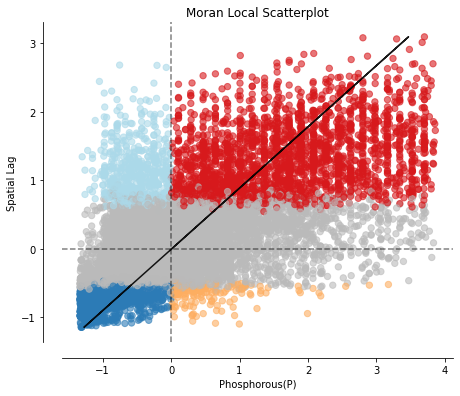

In [24]:
# visualize the local autocorrelation
from splot.esda import moran_scatterplot
from esda.moran import Moran_Local

# calculate Moran_Local and plot
moran_loc = Moran_Local(y, w)
fig, ax = moran_scatterplot(moran_loc, p=0.05)
ax.set_xlabel('Phosphorous(P)')
ax.set_ylabel('Spatial Lag')
plt.show()

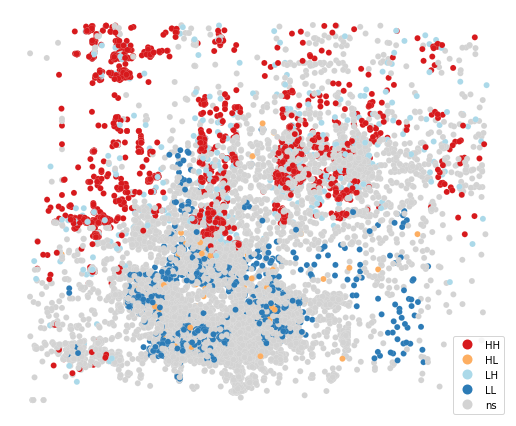

In [25]:
# show the significantly correlated area on the map
from splot.esda import lisa_cluster

lisa_cluster(moran_loc, gdf_, p=0.05, figsize = (9,9))
plt.show()

In the above plot, red dots are corresponding to high autocorrelation of similarity.

#### Stationarity

In [29]:
from skgstat import Variogram, OrdinaryKriging

In [30]:
%%time
#estimate variogram
data_ = train.copy()
lat, lon = data_['lat'].to_numpy(), data_['lon'].to_numpy()
cordinates = np.asarray([(lat[i], lon[i]) for i in range(len(lat))])
variogram = Variogram(cordinates, data_['P'].values,
                          n_lags = 25,
                          maxlag=0.5,
                          model = 'spherical',
                          bin_func='even',
                          use_nugget=True,
                          verbose = True)

CPU times: user 40 s, sys: 13.7 s, total: 53.7 s
Wall time: 54.2 s


plotting...


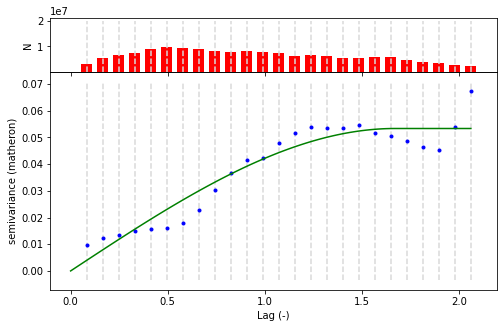

In [31]:
variogram.plot(show = False)
print("plotting...")

In [32]:
# Since the variogram
range_, sill, nugget = variogram.parameters
print(f"Range: {range_}\nsill: {sill}\nnugget: {nugget}")

Range: 1.6710938185546498
sill: 0.05334464642266317
nugget: 3.008869478161638e-23


since the variogram is bounded(sill defined), therefore no trend is there is the data, so we can that there is stationarity in the data.

In [33]:
data.lat.min(), data.lat.max()

(17.89472222, 20.59805556)

In [34]:
data.lon.min(), data.lon.max()

(73.38416667, 76.675)

In [35]:
from skgstat import  OrdinaryKriging

In [36]:
## Ordiinary kriging
ok = OrdinaryKriging(variogram, min_points=1, max_points=15, mode='exact')

In [37]:
xx, yy = np.mgrid[17:21:500j, 73:77:500j]
field = ok.transform(xx.flatten(), yy.flatten()).reshape(xx.shape)

In [40]:
def interpolate(V, model, field):
#     xx, yy = np.mgrid[18:21:500j, 73:77:500j]
#     field = model.transform(xx.flatten(), yy.flatten()).reshape(xx.shape)
    plt.pcolormesh(xx, yy, field, vmin = 0, vmax=1, cmap='viridis_r')
    plt.title('%s model' % V.model.__name__)
    plt.colorbar()
    return field

CPU times: user 57.5 ms, sys: 6.8 ms, total: 64.3 ms
Wall time: 71.7 ms


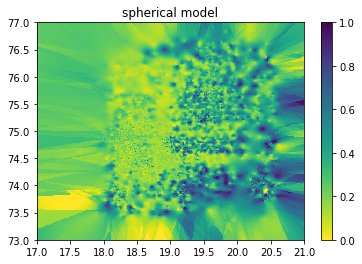

In [41]:
%%time
field = interpolate(variogram, ok, field)

In [42]:
with open("P_krig_interpolation.npy", "wb") as f:
    np.save(f, field)

In [43]:
%%time
# R2 value
field_pred = ok.transform(test.lat.values, test.lon.values)

CPU times: user 22 s, sys: 1min 8s, total: 1min 30s
Wall time: 19.2 s


In [50]:
r2 = r2_score(test.P.values, field_pred)
r2

0.41581002369074194

In [51]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [52]:
mae = mean_absolute_error(test.P.values, field_pred)
mae

0.09379206780292665

In [53]:
mse = mean_squared_error(test.P.values, field_pred)
mse**0.5

0.1485945561363321